## Import Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

## Synthetic Data

In [2]:
# Step 1: Generate synthetic data with added patterns
np.random.seed(42)

##### creates reliable random data across runs by setting the random seed for reproducibility.

In [3]:
# Create synthetic user profiles with clusters
num_users = 200
num_features = 15
user_profiles = np.random.rand(num_users, num_features)

##### creates 200 fictitious user profiles with 15 random attributes (values ranging from 0 to 1) for each user.

In [4]:
# Create clusters for users (simulate distinct preferences)
user_profiles[:50] += 0.5
user_profiles[50:100] -= 0.5

##### By biassing the first 50 users and the subsequent 50 users to represent different user groups, it adds clustering to user profiles.

In [5]:
# Create synthetic workout features with patterns
num_workouts = 80
workout_features = np.random.rand(num_workouts, num_features)

##### 80 exercises are produced, each with 15 arbitrary features.

In [6]:
# Introduce a bias: align some workouts with specific user clusters
workout_features[:20] += 0.3
workout_features[20:40] -= 0.3

##### By biassing the first 20 and subsequent 20 workouts, it adds patterns to workouts and simulates workout preferences that correspond with particular user clusters.

In [7]:
# Create synthetic interaction data (ratings) with added patterns
ratings = np.zeros((num_users, num_workouts))
for i in range(num_users):
    for j in range(num_workouts):
        ratings[i, j] = np.dot(user_profiles[i], workout_features[j]) + np.random.normal(0, 0.2)
ratings = np.clip(np.round(ratings), 1, 5)

##### By biassing the first 20 and subsequent 20 workouts, it adds patterns to workouts and simulates workout preferences that correspond with particular user clusters.

## Data Preparation

In [8]:
# Step 2: Data Preparation
user_ids, workout_ids = np.where(ratings > 0)
data = pd.DataFrame({
    'user_id': user_ids,
    'workout_id': workout_ids,
    'rating': ratings[user_ids, workout_ids]
})

##### generates a DataFrame with the ratings for each workout and user ID.

In [9]:
# Create user and workout feature DataFrames
user_features = pd.DataFrame(user_profiles, columns=[f'user_feat_{i}' for i in range(num_features)])
workout_features = pd.DataFrame(workout_features, columns=[f'workout_feat_{i}' for i in range(num_features)])

##### creates DataFrames with the column names user_feat_0, user_feat_1,..., and workout_feat_14 by converting user and workout features.

In [10]:
# Merge features into the dataset
data = data.merge(user_features, left_on='user_id', right_index=True)
data = data.merge(workout_features, left_on='workout_id', right_index=True, suffixes=('_user', '_workout'))

##### Merges user and workout features into the main dataset, aligning features with user and workout IDs.

## Data Wrangling

In [11]:
data.head()

,user_id,workout_id,rating,user_feat_0,user_feat_1,user_feat_2,user_feat_3,user_feat_4,user_feat_5,user_feat_6,...,workout_feat_5,workout_feat_6,workout_feat_7,workout_feat_8,workout_feat_9,workout_feat_10,workout_feat_11,workout_feat_12,workout_feat_13,workout_feat_14
0,0,0,5.0,0.87454,1.450714,1.231994,1.098658,0.656019,0.655995,0.558084,...,1.132830,1.206087,0.312157,0.974020,0.351836,0.848859,0.587633,0.606777,0.652959,0.921292
1,0,1,5.0,0.87454,1.450714,1.231994,1.098658,0.656019,0.655995,0.558084,...,0.585758,0.732767,0.985444,0.632456,0.356586,0.673921,1.244449,0.941734,0.971479,0.932282
2,0,2,5.0,0.87454,1.450714,1.231994,1.098658,0.656019,0.655995,0.558084,...,0.576319,0.732019,1.280369,0.367503,0.818701,0.479365,1.270677,0.413304,0.703601,1.037885
3,0,3,5.0,0.87454,1.450714,1.231994,1.098658,0.656019,0.655995,0.558084,...,0.505333,0.783040,0.568534,0.587462,0.956756,1.268537,0.903637,0.376979,0.375584,1.251423
4,0,4,5.0,0.87454,1.450714,1.231994,1.098658,0.656019,0.655995,0.558084,...,0.567402,0.315111,1.265015,0.550893,0.976026,1.006630,0.910007,0.612907,0.571096,0.897668


In [12]:
data.sample()

,user_id,workout_id,rating,user_feat_0,user_feat_1,user_feat_2,user_feat_3,user_feat_4,user_feat_5,user_feat_6,...,workout_feat_5,workout_feat_6,workout_feat_7,workout_feat_8,workout_feat_9,workout_feat_10,workout_feat_11,workout_feat_12,workout_feat_13,workout_feat_14
3221,40,21,4.0,0.668935,0.77859,0.67701,0.588703,0.620636,0.960779,0.706334,...,0.248419,-0.233537,0.466515,0.283714,0.48196,0.451747,0.503002,0.218008,-0.159675,0.371157


In [13]:
data.tail()

,user_id,workout_id,rating,user_feat_0,user_feat_1,user_feat_2,user_feat_3,user_feat_4,user_feat_5,user_feat_6,...,workout_feat_5,workout_feat_6,workout_feat_7,workout_feat_8,workout_feat_9,workout_feat_10,workout_feat_11,workout_feat_12,workout_feat_13,workout_feat_14
15995,199,75,3.0,0.967035,0.051669,0.504796,0.718454,0.86264,0.179256,0.800003,...,0.271955,0.217891,0.661835,0.633712,0.593461,0.016243,0.728778,0.323530,0.665056,0.556578
15996,199,76,3.0,0.967035,0.051669,0.504796,0.718454,0.86264,0.179256,0.800003,...,0.649788,0.103434,0.402027,0.728939,0.779821,0.118219,0.000031,0.712137,0.356596,0.254481
15997,199,77,3.0,0.967035,0.051669,0.504796,0.718454,0.86264,0.179256,0.800003,...,0.514461,0.085056,0.548873,0.379979,0.607135,0.388726,0.240299,0.094965,0.314918,0.096645
15998,199,78,3.0,0.967035,0.051669,0.504796,0.718454,0.86264,0.179256,0.800003,...,0.995569,0.582714,0.812474,0.326941,0.305744,0.402704,0.672507,0.682192,0.315239,0.133210
15999,199,79,4.0,0.967035,0.051669,0.504796,0.718454,0.86264,0.179256,0.800003,...,0.753472,0.872859,0.499959,0.730249,0.619173,0.186640,0.025690,0.284541,0.443034,0.617106


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          16000 non-null  int64  
 1   workout_id       16000 non-null  int64  
 2   rating           16000 non-null  float64
 3   user_feat_0      16000 non-null  float64
 4   user_feat_1      16000 non-null  float64
 5   user_feat_2      16000 non-null  float64
 6   user_feat_3      16000 non-null  float64
 7   user_feat_4      16000 non-null  float64
 8   user_feat_5      16000 non-null  float64
 9   user_feat_6      16000 non-null  float64
 10  user_feat_7      16000 non-null  float64
 11  user_feat_8      16000 non-null  float64
 12  user_feat_9      16000 non-null  float64
 13  user_feat_10     16000 non-null  float64
 14  user_feat_11     16000 non-null  float64
 15  user_feat_12     16000 non-null  float64
 16  user_feat_13     16000 non-null  float64
 17  user_feat_14

In [15]:
data.dtypes

user_id              int64
workout_id           int64
rating             float64
user_feat_0        float64
user_feat_1        float64
user_feat_2        float64
user_feat_3        float64
user_feat_4        float64
user_feat_5        float64
user_feat_6        float64
user_feat_7        float64
user_feat_8        float64
user_feat_9        float64
user_feat_10       float64
user_feat_11       float64
user_feat_12       float64
user_feat_13       float64
user_feat_14       float64
workout_feat_0     float64
workout_feat_1     float64
workout_feat_2     float64
workout_feat_3     float64
workout_feat_4     float64
workout_feat_5     float64
workout_feat_6     float64
workout_feat_7     float64
workout_feat_8     float64
workout_feat_9     float64
workout_feat_10    float64
workout_feat_11    float64
workout_feat_12    float64
workout_feat_13    float64
workout_feat_14    float64
dtype: object

In [16]:
data.columns

Index(['user_id', 'workout_id', 'rating', 'user_feat_0', 'user_feat_1',
       'user_feat_2', 'user_feat_3', 'user_feat_4', 'user_feat_5',
       'user_feat_6', 'user_feat_7', 'user_feat_8', 'user_feat_9',
       'user_feat_10', 'user_feat_11', 'user_feat_12', 'user_feat_13',
       'user_feat_14', 'workout_feat_0', 'workout_feat_1', 'workout_feat_2',
       'workout_feat_3', 'workout_feat_4', 'workout_feat_5', 'workout_feat_6',
       'workout_feat_7', 'workout_feat_8', 'workout_feat_9', 'workout_feat_10',
       'workout_feat_11', 'workout_feat_12', 'workout_feat_13',
       'workout_feat_14'],
      dtype='object')

In [17]:
data.isnull().sum()

user_id            0
workout_id         0
rating             0
user_feat_0        0
user_feat_1        0
user_feat_2        0
user_feat_3        0
user_feat_4        0
user_feat_5        0
user_feat_6        0
user_feat_7        0
user_feat_8        0
user_feat_9        0
user_feat_10       0
user_feat_11       0
user_feat_12       0
user_feat_13       0
user_feat_14       0
workout_feat_0     0
workout_feat_1     0
workout_feat_2     0
workout_feat_3     0
workout_feat_4     0
workout_feat_5     0
workout_feat_6     0
workout_feat_7     0
workout_feat_8     0
workout_feat_9     0
workout_feat_10    0
workout_feat_11    0
workout_feat_12    0
workout_feat_13    0
workout_feat_14    0
dtype: int64

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,16000.0,99.500000,57.736110,0.000000,49.750000,99.500000,149.250000,199.000000
workout_id,16000.0,39.500000,23.092928,0.000000,19.750000,39.500000,59.250000,79.000000
rating,16000.0,3.117437,1.685511,1.000000,1.000000,3.000000,5.000000,5.000000
user_feat_0,16000.0,0.539983,0.470219,-0.489004,0.201215,0.539090,0.871112,1.490505
user_feat_1,16000.0,0.470928,0.489985,-0.495060,0.104812,0.480184,0.854229,1.486515
user_feat_2,16000.0,0.497887,0.438400,-0.477876,0.177869,0.512616,0.782919,1.432728
user_feat_3,16000.0,0.490652,0.463465,-0.468866,0.122902,0.460435,0.824182,1.474395
user_feat_4,16000.0,0.493417,0.456168,-0.488379,0.134208,0.536216,0.796767,1.486211
user_feat_5,16000.0,0.491087,0.466059,-0.442157,0.157561,0.452620,0.859126,1.475852
user_feat_6,16000.0,0.523300,0.436096,-0.481609,0.212160,0.541397,0.818310,1.499718


## Data Visualization

### Rating Distribution

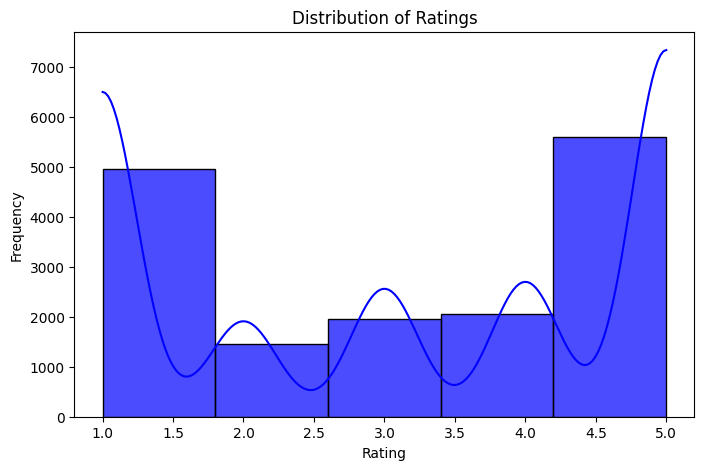

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(data['rating'], bins=5, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


If ratings are skewed toward high values (e.g., 4 and 5), it suggests users tend to rate workouts positively.
A lack of ratings in the middle range might indicate users either love or dislike a workout, which could influence the recommendation system's performance.

### Correlation Heatmap

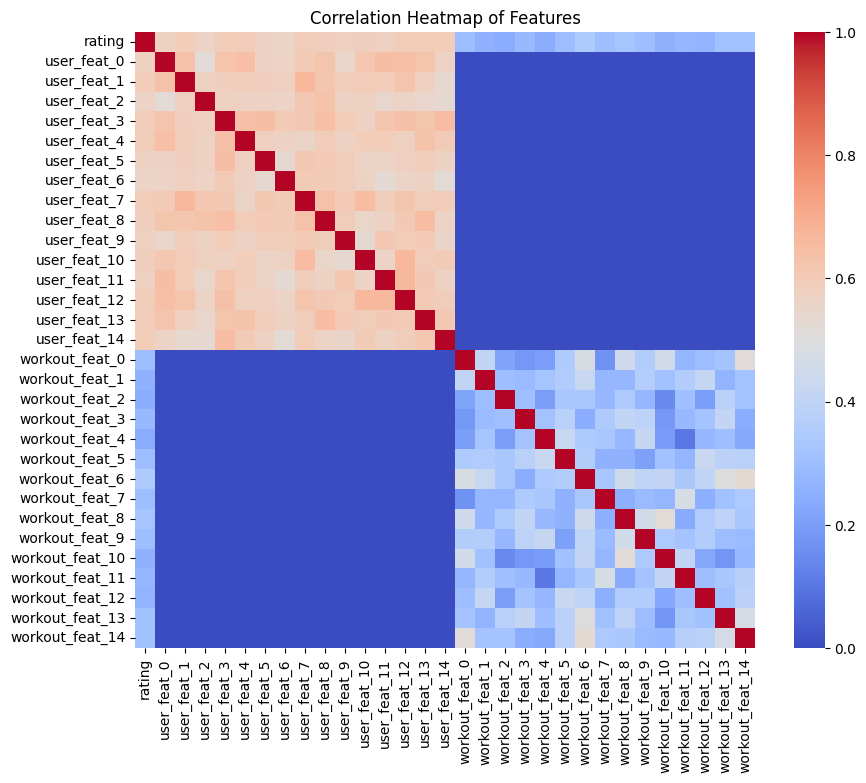

In [20]:
# Compute correlation for user and workout features with ratings
corr_matrix = data.drop(columns=['user_id', 'workout_id']).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Features')
plt.show()


This heatmap visualizes the pairwise correlations between features and the target variable (rating).
Strong correlations (positive or negative) with rating help identify which user or workout features are most influential.
Features with near-zero correlations might not significantly impact model performance and could potentially be removed to simplify the model.

### Top Rated Workouts

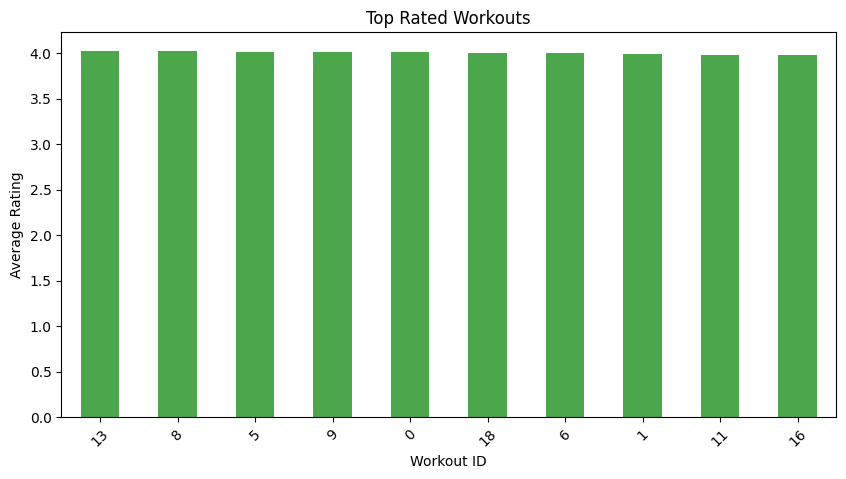

In [21]:
# Calculate average ratings for each workout
top_workouts = data.groupby('workout_id')['rating'].mean().sort_values(ascending=False).head(10)

# Plot the top workouts
plt.figure(figsize=(10, 5))
top_workouts.plot(kind='bar', color='green', alpha=0.7)
plt.title('Top Rated Workouts')
plt.xlabel('Workout ID')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()


This bar chart displays the workouts with the highest average ratings.
High ratings might indicate these workouts are universally appealing or cater to a specific group of users.
Understanding these trends can help in designing similar workouts or targeting users likely to engage with these.

### User-Workout Interactions (Heatmap)

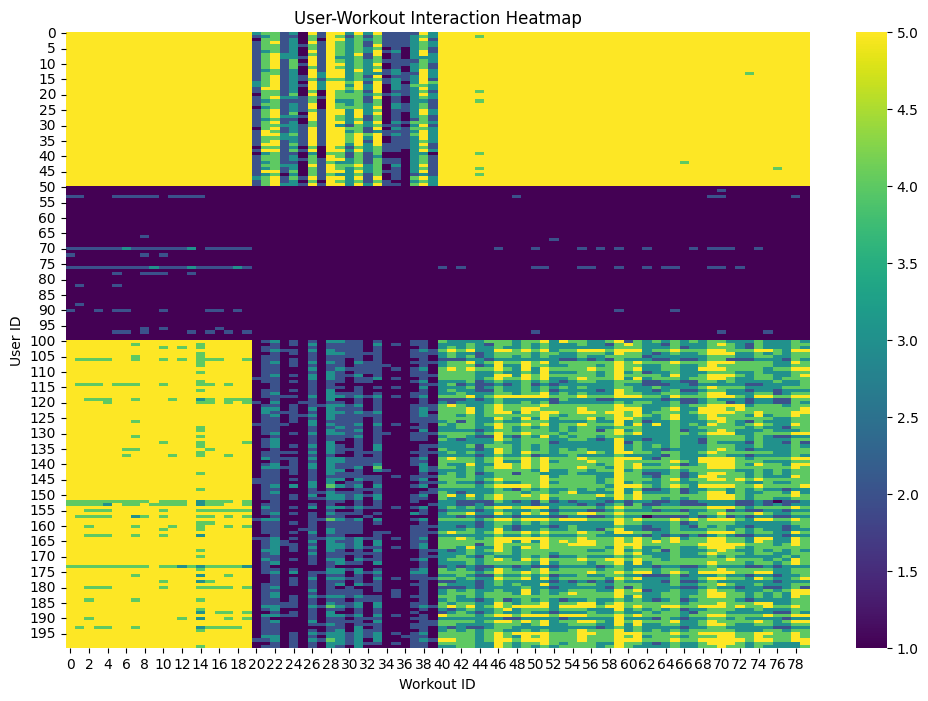

In [22]:
# Create a pivot table for user-workout interactions
user_workout_matrix = data.pivot_table(index='user_id', columns='workout_id', values='rating', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(user_workout_matrix, cmap='viridis', cbar=True)
plt.title('User-Workout Interaction Heatmap')
plt.xlabel('Workout ID')
plt.ylabel('User ID')
plt.show()


This heatmap shows which users have interacted with which workouts.
Brighter colors represent higher ratings, indicating user preference for specific workouts.
Sparse areas (darker colors) suggest workouts that users have not rated or used much, which could be candidates for better promotion or personalization.

### Feature Importance via Pairwise Plots

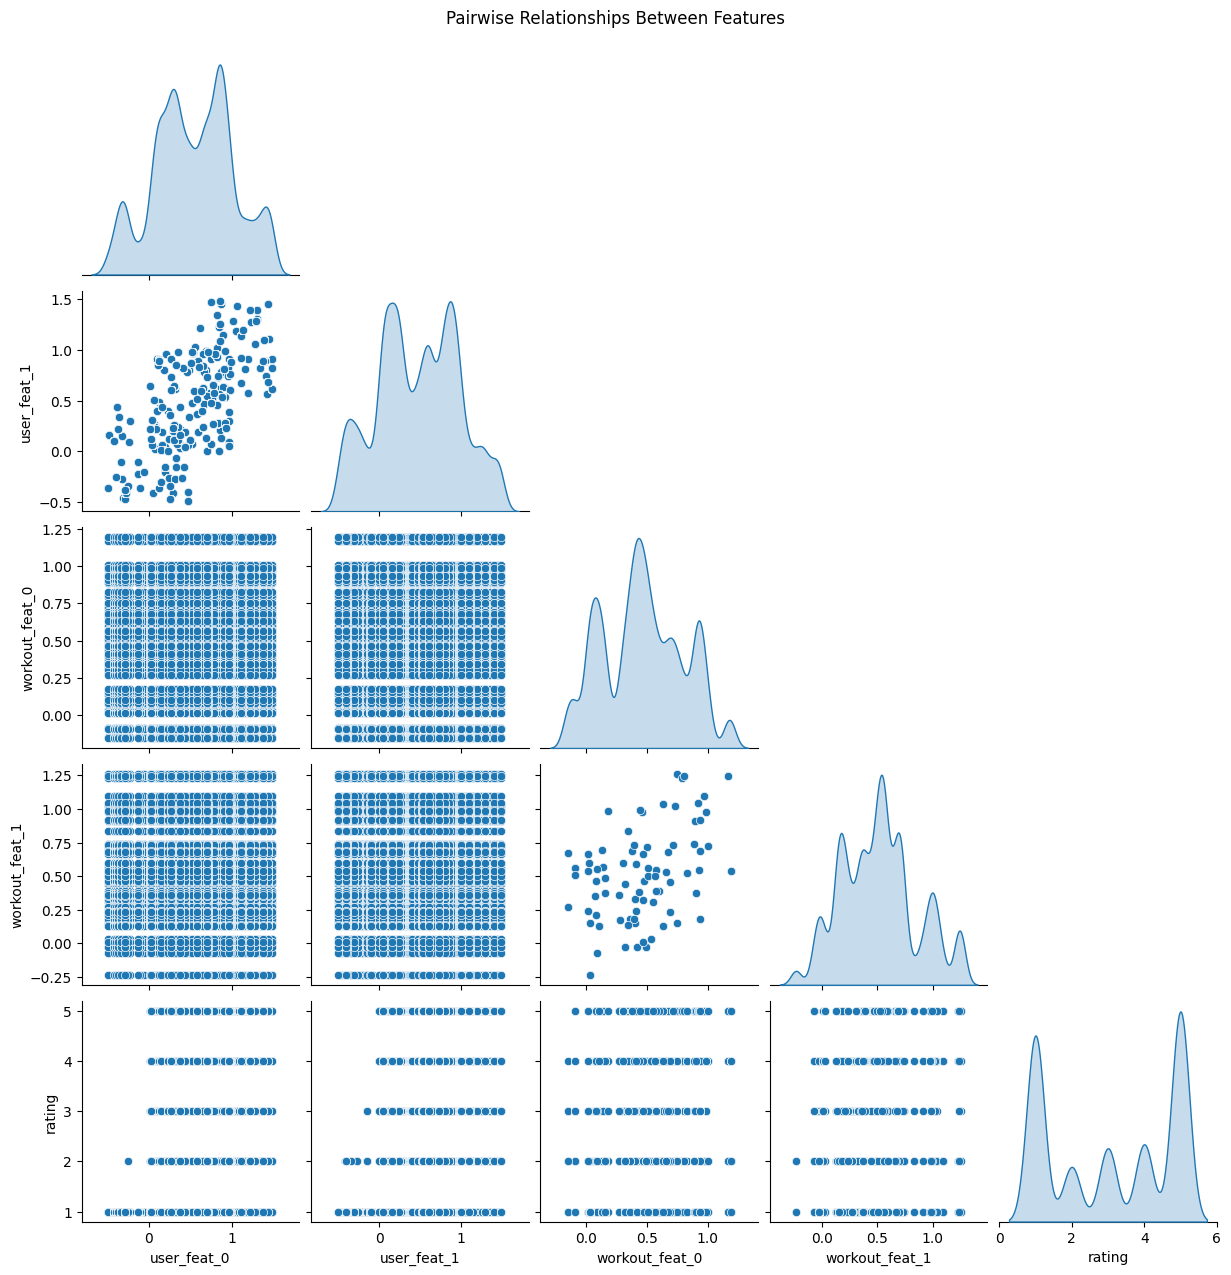

In [23]:
# Use only a subset of features to make the plot readable
feature_cols = ['user_feat_0', 'user_feat_1', 'workout_feat_0', 'workout_feat_1', 'rating']

# Pairplot to visualize relationships
sns.pairplot(data[feature_cols], diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships Between Features', y=1.02)
plt.show()


This plot highlights the relationships between selected features and the target variable (rating).
For example, if user_feat_0 has a clear upward trend with rating, it suggests that higher values of this feature lead to better ratings.
The KDE (kernel density estimate) on the diagonal shows the distribution of individual features, revealing any skewness or concentration in their values.

## Split the Data

In [24]:
# Step 3: Split the data
X = data.drop(columns=['rating', 'user_id', 'workout_id'])
y = data['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### divides the dataset into target labels (y) and features (X). Because they are not required for training, user_id and workout_id are dropped.
Splits the data into training and testing sets, with 20% reserved for testing.

## Normalize Features and Apply PCA

In [25]:
# Step 4: Normalize features and apply PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Scales features to have a mean of 0 and standard deviation of 1, ensuring uniform input ranges for the SVM.

In [26]:
pca = PCA(n_components=10)  # Reduce to 10 components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

##### minimises noise while keeping the most significant patterns in the data by decreasing dimensionality to 10 major components.

## Train an Optimized SVM Model

In [27]:
# Step 5: Train an optimized SVM model
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.1, 0.01]}
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train_pca, y_train)

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 0.1, 0.01]},
             scoring='neg_mean_squared_error')

##### specifies a grid of hyperparameters (gamma and C) for using an RBF kernel to tune the SVM. To determine the optimal parameters based on MSE, 3-fold cross-validation is used.

In [28]:
svm_model = grid_search.best_estimator_

##### Retrieves the best SVM model from the grid search.

## Evaluate the Model

In [29]:
# Step 6: Evaluate the model
predictions = svm_model.predict(X_test_pca)

##### Uses the trained model to predict ratings for the test set.

In [30]:
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

##### Computes evaluation metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² score.

In [31]:
# Cross-validation for robustness
cv_scores = cross_val_score(svm_model, X_train_pca, y_train, scoring='neg_mean_squared_error', cv=5)

##### Computes cross-validated MSE on the training data to validate the model’s generalizability.

In [32]:
# Output results
print("Enhanced Recommendation System Evaluation:")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Error: {r2}")
print(f"Cross-validated MSE: {-np.mean(cv_scores)}")

Enhanced Recommendation System Evaluation:
Mean Squared Error: 0.0998193703756117
Mean Absolute Error: 0.19819637678543692
R2 Error: 0.9652481065504189
Cross-validated MSE: 0.10204799084440026


##### Outputs the evaluation results.